# Yearly Extent
Here, we construct figures showcasing the evolution of yearly defoliation extent from 2020 to 2023.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.transform import array_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import ultraplot as uplt

## Load Data

In [2]:
new_york_2019 = rio.open('./Data/as_satellite_comp_1000_2019.tif', 'r')
new_york_2020 = rio.open('./Data/as_satellite_comp_1000_2020.tif', 'r')
new_york_2021 = rio.open('./Data/as_satellite_comp_1000_2021.tif', 'r')
new_york_2022 = rio.open('./Data/as_satellite_comp_1000_2022.tif', 'r')
new_york_2023 = rio.open('./Data/as_satellite_comp_1000_2023.tif', 'r')

In [3]:
trend = pd.read_csv('./Data/area_sums.csv')
trend['defol'] /= 1000000
trend['severe'] /= 1000000
trend['non_severe'] = trend['defol'] - trend['severe']
trend = trend.set_index(trend['year'])

In [4]:
def process_forest_tiles(filename):
    df = gpd.read_file(filename)
    df['defol_forest_2'] = df['defoliation_2']/df['forest']
    df['defol_forest_mask_2'] = df['defoliation_2']/df['qa_mask_2']
    df['defol_forest_3'] = df['defoliation_3']/df['forest']
    df['defol_forest_mask_3'] = df['defoliation_3']/df['qa_mask_3']
    return df

forest_2020 = process_forest_tiles('./Data/TimeImpacts/forest_grid_2020.geojson')
forest_2021 = process_forest_tiles('./Data/TimeImpacts/forest_grid_2021.geojson')
forest_2022 = process_forest_tiles('./Data/TimeImpacts/forest_grid_2022.geojson')
forest_2023 = process_forest_tiles('./Data/TimeImpacts/forest_grid_2023.geojson')

In [30]:
min_prop = 3/4
forest_2020['suf_obs'] = forest_2020['qa_mask_3']/forest_2020['forest'] >= min_prop
forest_2021['suf_obs'] = forest_2021['qa_mask_3']/forest_2021['forest'] >= min_prop
forest_2022['suf_obs'] = forest_2022['qa_mask_3']/forest_2022['forest'] >= min_prop
forest_2023['suf_obs'] = forest_2023['qa_mask_3']/forest_2023['forest'] >= min_prop

## Helper Functions

In [17]:
def add_raster_data(ax, image, bounds, year, crs, vmin, vmax, cmap):
    m = ax.imshow(image, cmap=cmap, levels=np.linspace(vmin, vmax, 11), transform=crs,
                  extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    ax.format(grid=False, facecolor='white', title=str(year))
    ax.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES)
    
    return m

In [18]:
def classify(image, threshold):
    image_thresh = image.copy()
    image_thresh = np.greater(image, threshold, out=image_thresh, where=~np.isnan(image))
    return image_thresh

## Prepare Extent Data

In [19]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs):
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=raster_file.read(),
        src_transform=raster_file.transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)

    new_image = new_image.transpose([1, 2, 0])
    new_bounds = array_bounds(new_image.shape[0], new_image.shape[1], new_transform)
    
    return new_image, new_bounds

# 2019
image_2019, bounds_2019 = prepare_for_viz(new_york_2019, dest_crs)

# 2020
image_2020, bounds_2020 = prepare_for_viz(new_york_2020, dest_crs)

# 2021
image_2021, bounds_2021 = prepare_for_viz(new_york_2021, dest_crs)

# 2022
image_2022, bounds_2022 = prepare_for_viz(new_york_2022, dest_crs)

# 2023
image_2023, bounds_2023 = prepare_for_viz(new_york_2023, dest_crs)

In [20]:
cutoff = 0.1

threshold_2019 = classify(image_2019[:, :, 0], cutoff)
threshold_2020 = classify(image_2020[:, :, 0], cutoff)
threshold_2021 = classify(image_2021[:, :, 0], cutoff)
threshold_2022 = classify(image_2022[:, :, 0], cutoff)
threshold_2023 = classify(image_2023[:, :, 0], cutoff)

# Plot extent maps

## Combined Maps and Yearly Extent

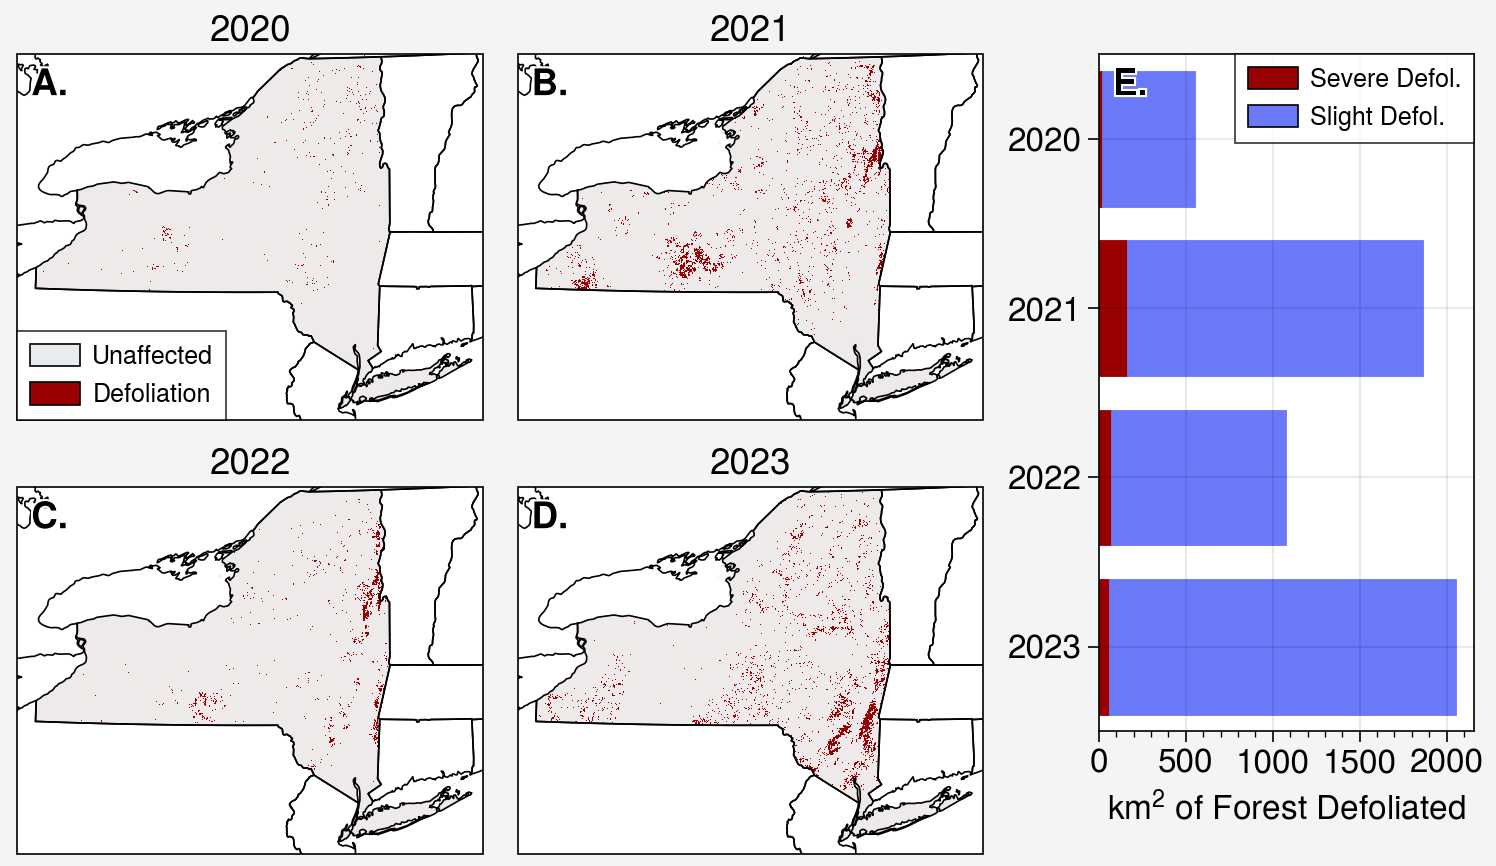

In [21]:
layout = [[1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0,],]

fig, axes = uplt.subplots(layout, figsize=('190mm','110mm'), proj={(1, 2, 3, 4):dest_crs}, 
                          facecolor='white', fontsize=12, share=False)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)

# Raster Legend
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
axes[0].legend(loc='lower left', handles=[no_patch, defol_patch],  ncols=1)

# Create annual extent graph
axes[4].barh(trend[['severe', 'non_severe']], stack=True,
             cycle=uplt.Cycle(colors=[cmap[1], 'cornflower']))
axes[4].format( xlabel='km$^2$ of Forest Defoliated', 
               yminorticks='none', yticks=[2023, 2022, 2021, 2020], ylim=[2023.5, 2019.5])
defol_patch = mpatches.Patch(facecolor='cornflower', label='Slight Defol.', edgecolor='black')
severe_patch = mpatches.Patch(facecolor=cmap[1], label='Severe Defol.', edgecolor='black')
axes[4].legend(loc='upper right', handles=[severe_patch, defol_patch],  ncols=1)

#fig.savefig('./Figures/YearlyExtent/extent_upscaled_2020_to_2023.png')

## Seperate Maps and Yealy Extent

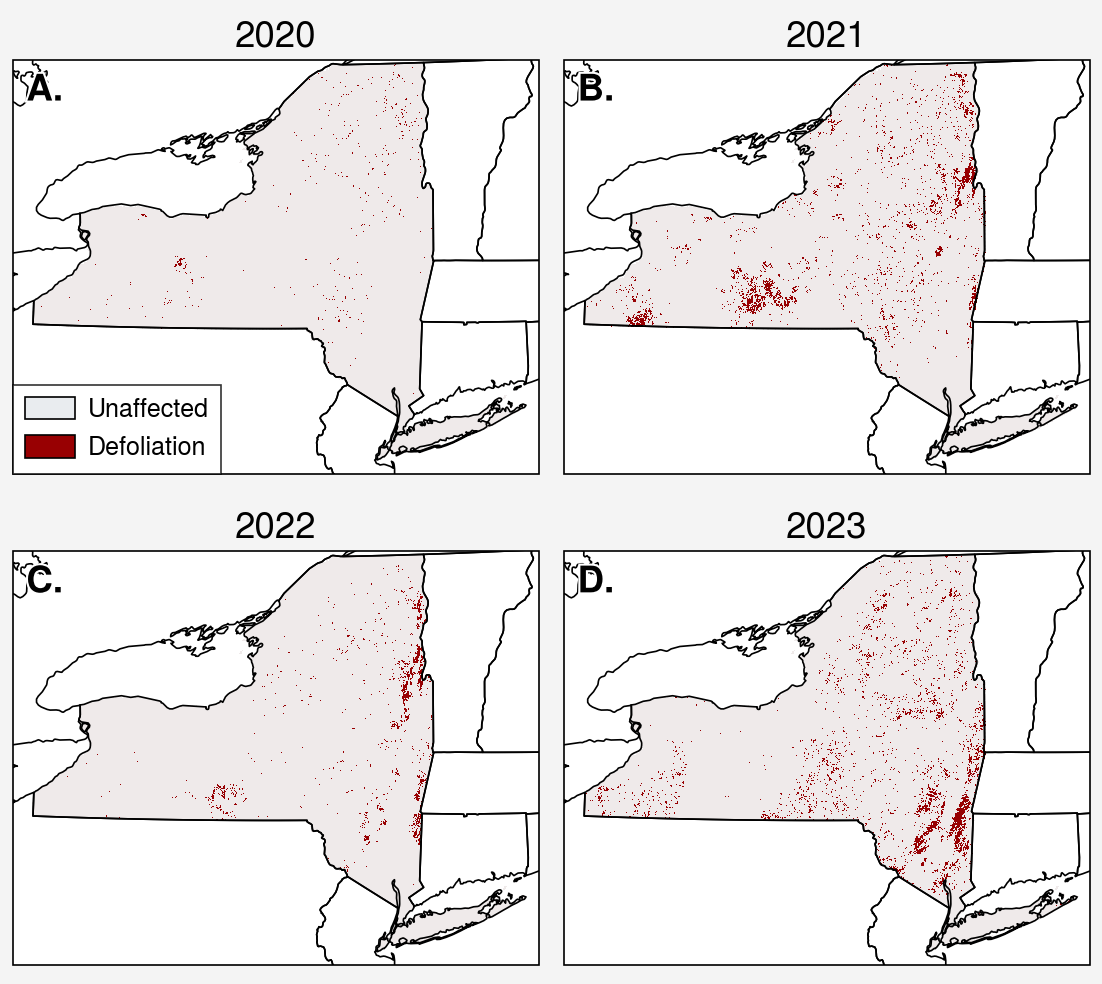

In [22]:
fig, axes = uplt.subplots(ncols=2, nrows=2, figsize=('140mm','125mm'), proj=dest_crs, 
                          facecolor='white', fontsize=12, share=False)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)

# Raster Legend
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
axes[0].legend(loc='lower left', handles=[no_patch, defol_patch],  ncols=1)

#fig.savefig('./Figures/YearlyExtent/extent_upscaled_2020_to_2023.png')

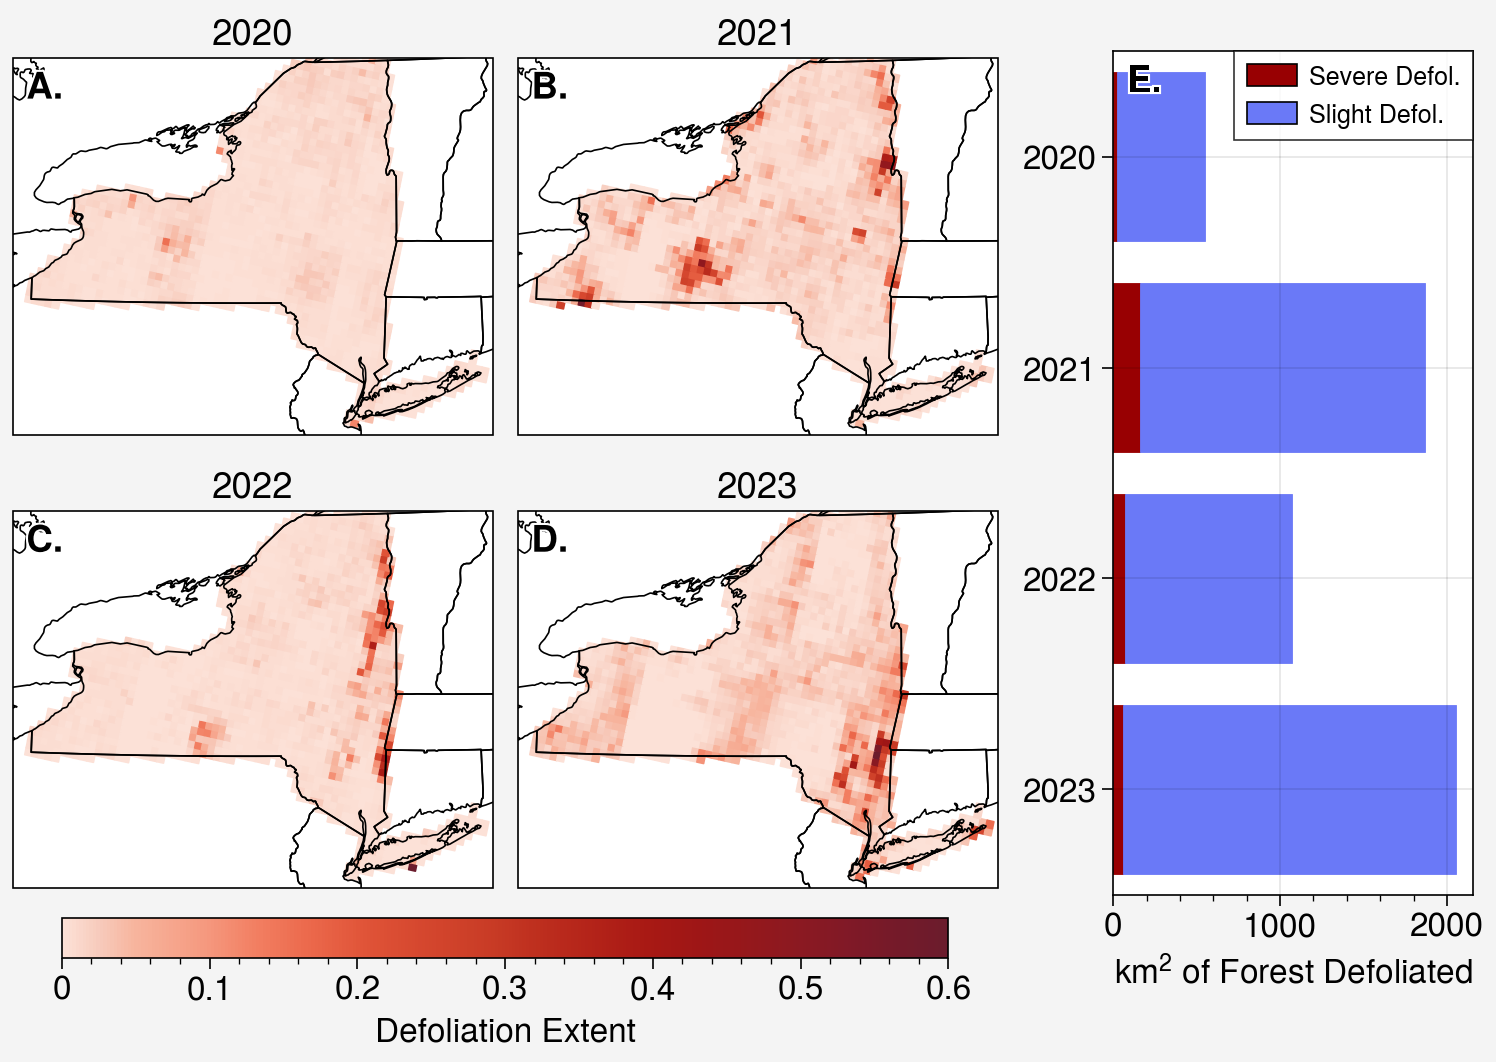

In [25]:
layout = [[1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],]

fig, axes = uplt.subplots(layout, figsize=('190mm','135mm'), proj={(1, 2, 3, 4):dest_crs}, 
                          facecolor='white', fontsize=12, share=False)

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=0, vmax=0.6)
cmap = uplt.Colormap('Reds3')
cmap_bars = ['gray2', 'blood red']

for i, forest in enumerate([forest_2020, forest_2021, forest_2022, forest_2023]):
    if forest is None:
        continue
    for row in forest.itertuples():
        region = cfeature.ShapelyFeature(
            row.geometry,
            ccrs.epsg(5070),
            facecolor=cmap(norm(row.defol_forest_3)),
            edgecolor=cmap(norm(row.defol_forest_3)))
        axes[i].add_feature(region)
    axes[i].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.STATES)
    axes[i].format(grid=False, facecolor='white', title=str(2020 + i))

fig.colorbar(cmap, vmin=norm.vmin, vmax=norm.vmax, 
             loc='b', cols=[1,8], length=0.9, 
             label="Defoliation Extent", labelsize=12, ticklabelsize=12)

# Create annual extent graph
axes[4].barh(trend[['severe', 'non_severe']], stack=True,
             cycle=uplt.Cycle(colors=[cmap_bars[1], 'cornflower']))
axes[4].format( xlabel='km$^2$ of Forest Defoliated', 
               yminorticks='none', yticks=[2023, 2022, 2021, 2020], ylim=[2023.5, 2019.5])
defol_patch = mpatches.Patch(facecolor='cornflower', label='Slight Defol.', edgecolor='black')
severe_patch = mpatches.Patch(facecolor=cmap_bars[1], label='Severe Defol.', edgecolor='black')
axes[4].legend(loc='upper right', handles=[severe_patch, defol_patch],  ncols=1)

#fig.savefig('./Figures/YearlyExtent/extent_upscaled_10k_2020_to_2023.png')

C:\Users\camer\miniforge3\envs\defoliation\Lib\site-packages\ultraplot\figure.py:2063: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb = super().colorbar(mappable, cax=cax, **kwargs)


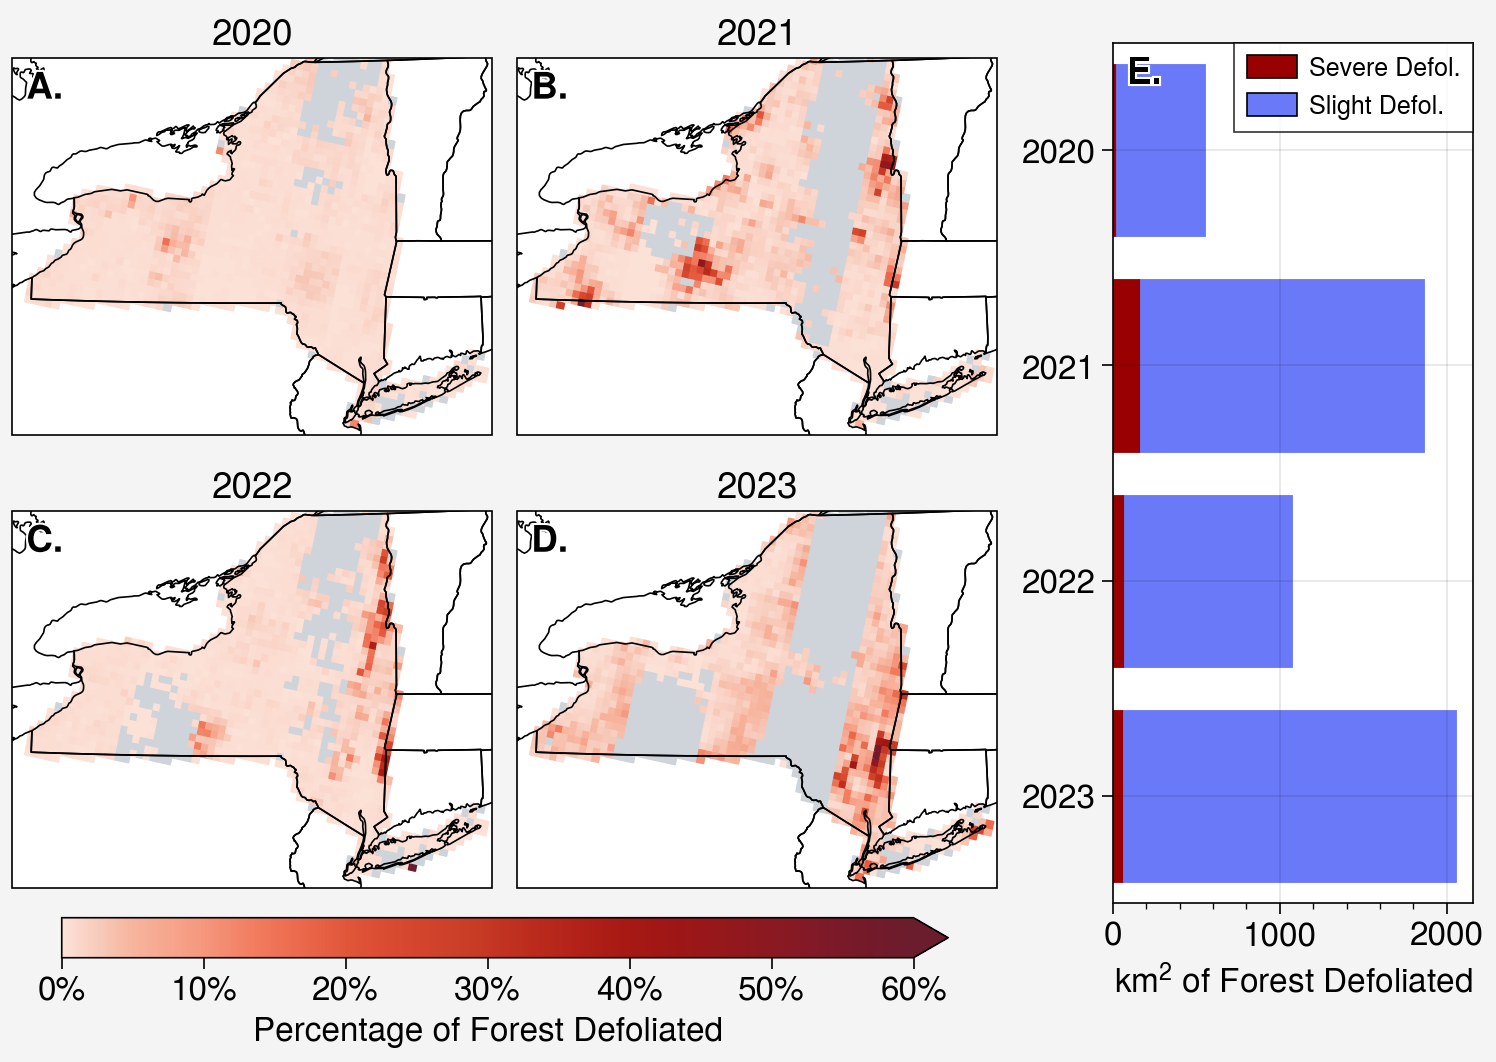

In [35]:
layout = [[1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [1, 1, 1, 1, 2, 2, 2, 2, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],
          [3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5,],]

fig, axes = uplt.subplots(layout, figsize=('190mm','135mm'), proj={(1, 2, 3, 4):dest_crs}, 
                          facecolor='white', fontsize=12, share=False)

axes.format(abc='A.', abcloc='ul')

norm = plt.colors.Normalize(vmin=0, vmax=0.6)
cmap = uplt.Colormap('Reds3')
cmap_bars = ['gray2', 'blood red']

for i, forest in enumerate([forest_2020, forest_2021, forest_2022, forest_2023]):
    if forest is None:
        continue
    for row in forest.itertuples():
        if row.suf_obs:
            region = cfeature.ShapelyFeature(
                row.geometry,
                ccrs.epsg(5070),
                facecolor=cmap(norm(row.defol_forest_3)),
                edgecolor=cmap(norm(row.defol_forest_3)))
        else:
            region = cfeature.ShapelyFeature(
                row.geometry,
                ccrs.epsg(5070),
                facecolor='gray4',
                edgecolor='gray4')
        axes[i].add_feature(region)
    axes[i].set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.STATES)
    axes[i].format(grid=False, facecolor='white', title=str(2020 + i))

fig.colorbar(cmap, vmin=norm.vmin, vmax=norm.vmax, 
             loc='b', cols=[1,8], length=0.9, 
             label="Percentage of Forest Defoliated", labelsize=12, 
             ticklabels=['0%', '10%', '20%', '30%', '40%', '50%', '60%'], ticklabelsize=12,
             extend='max')

# Create annual extent graph
axes[4].barh(trend[['severe', 'non_severe']], stack=True,
             cycle=uplt.Cycle(colors=[cmap_bars[1], 'cornflower']))
axes[4].format( xlabel='km$^2$ of Forest Defoliated', 
               yminorticks='none', yticks=[2023, 2022, 2021, 2020], ylim=[2023.5, 2019.5])
defol_patch = mpatches.Patch(facecolor='cornflower', label='Slight Defol.', edgecolor='black')
severe_patch = mpatches.Patch(facecolor=cmap_bars[1], label='Severe Defol.', edgecolor='black')
axes[4].legend(loc='upper right', handles=[severe_patch, defol_patch],  ncols=1)

fig.savefig('./Figures/YearlyExtent/extent_upscaled_10k_2020_to_2023_masked.png')

In [ ]:
np.count_nonzero(forest_2020['forest'] >= forest_2020['qa_mask_3'])

In [37]:
np.log(0.00000001 + forest_2022['defol_forest_3']/(1 - forest_2022['defol_forest_3']))

0      -7.078282
1      -5.601579
2      -6.060978
3      -5.322923
4      -7.688490
          ...   
1420   -4.759588
1421   -4.128086
1422   -4.422438
1423   -4.990073
1424   -4.784463
Name: defol_forest_3, Length: 1425, dtype: float64

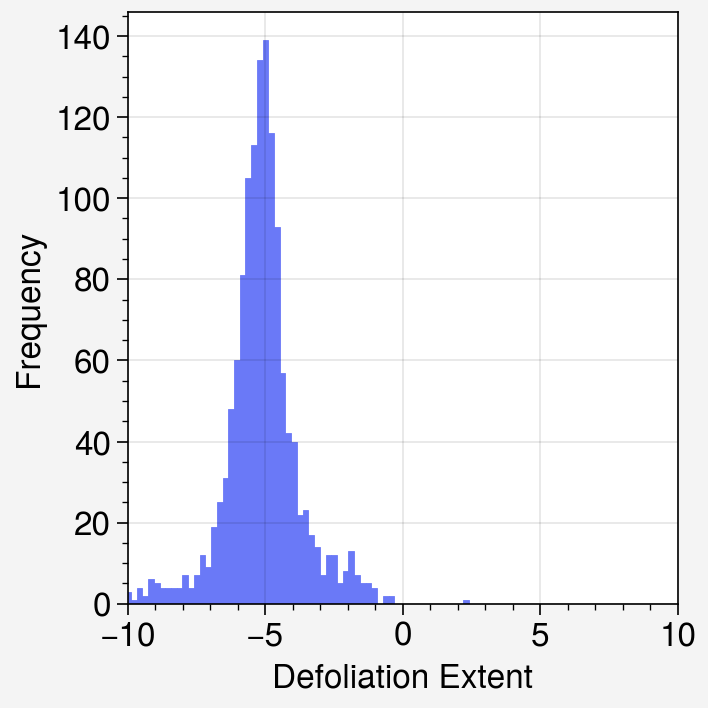

In [38]:
fig, ax = uplt.subplots(ncols=1, nrows=1, figsize=('90mm','90mm'), 
                          facecolor='white', fontsize=12, share=False)
cmap = ['gray2', 'blood red']

ax.hist(np.log(0.00000001 + forest_2022['defol_forest_3']/(1 - forest_2022['defol_forest_3'])),bins=100, color='cornflower')
ax.format(xlabel='Defoliation Extent', ylabel='Frequency', xlim=[-10, 10])

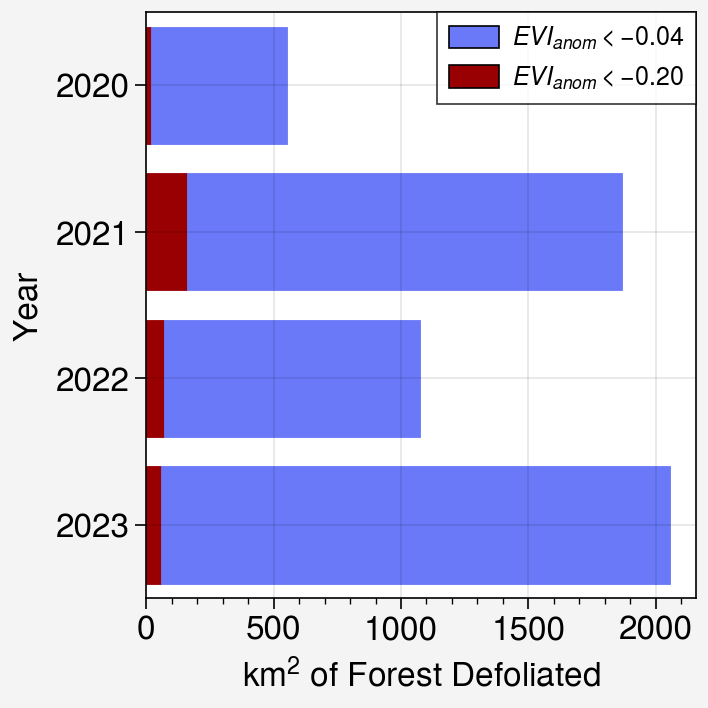

In [25]:
fig, axes = uplt.subplots(ncols=1, nrows=1, figsize=('90mm', '90mm'), 
                          facecolor='white', fontsize=12, share=False)
cmap = ['gray2', 'blood red']
# Create annual extent graph
axes[0].barh(trend[['severe', 'non_severe']], stack=True,
             cycle=uplt.Cycle(colors=[cmap[1], 'cornflower']))
axes[0].format(ylabel='Year', xlabel='km$^2$ of Forest Defoliated', 
               yminorticks='none', yticks=[2023, 2022, 2021, 2020],
              ylim=[2023.5, 2019.5])
defol_patch = mpatches.Patch(facecolor='cornflower', label='$EVI_{anom} < -0.04$', edgecolor='black')
severe_patch = mpatches.Patch(facecolor=cmap[1], label='$EVI_{anom} < -0.20$', edgecolor='black')
axes[0].legend(loc='upper right', handles=[defol_patch, severe_patch],  ncols=1)

fig.savefig('./Figures/YearlyExtent/total_area.png')

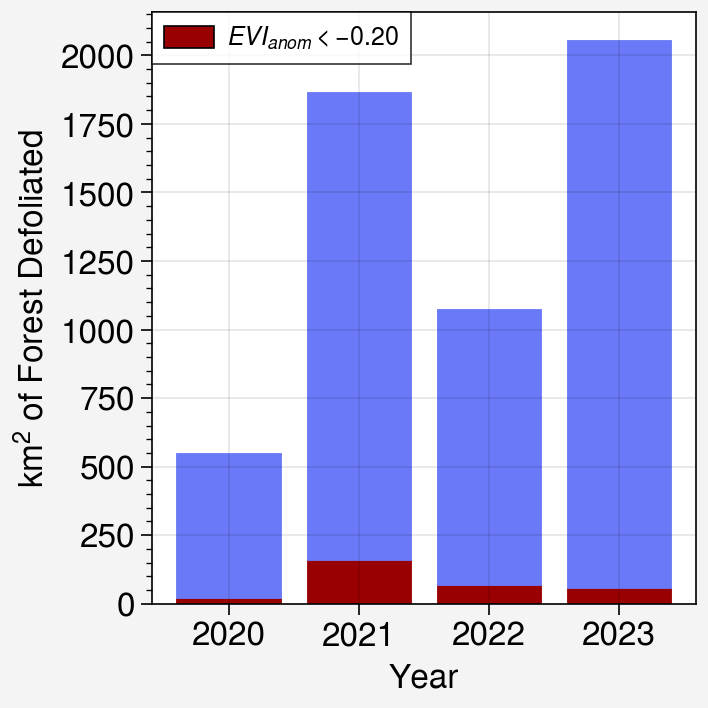

In [22]:
fig, axes = uplt.subplots(ncols=1, nrows=1, figsize=('90mm','90mm'), 
                          facecolor='white', fontsize=12, share=False)
cmap = ['gray2', 'blood red']
# Create annual extent graph
axes[0].bar(trend[['severe', 'non_severe']], stack=True,
             cycle=uplt.Cycle(colors=[cmap[1], 'cornflower']))
axes[0].format(xlabel='Year', ylabel='km$^2$ of Forest Defoliated', 
               xminorticks='none', xticks=[2023, 2022, 2021, 2020])
              #ylim=[2023.5, 2019.5])
defol_patch = mpatches.Patch(facecolor='cornflower', label='$EVI_{anom} < -0.04$', edgecolor='black')
severe_patch = mpatches.Patch(facecolor=cmap[1], label='$EVI_{anom} < -0.20$', edgecolor='black')
axes[0].legend(loc='upper left', handles=[severe_patch],  ncols=1)

In [ ]:
masked = forest[forest['forest'] > 10_000_000].copy()